<a href="https://colab.research.google.com/github/natrask/ENM5310/blob/main/Lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lecture Thurs 1/25

Today we're going to start building some complex models. The homework assignment for the coming week will delve into pencil and paper traditional statistical estimation for fitting simplistic models and working with probability distributions. Today however we're going to focus on how to build up some more complicated models.

### Step 1: Visualize data

Plot your dataset to understand trends, identify outliers, get order of estimate scaling. Much data will come in the form of a pandas dataframe - for a tutorial on working with dataframes take a look at [this 10 min guide to pandas](https://pandas.pydata.org/docs/user_guide/10min.html).

### Step 2: Build up a reasonable model
Postulate a model, derive expressions for joint distribution, log likelihood function, etc.

### Step 3: Implement in TF/Pytorch/JAX
Implement model in learning architecture. Build loss function. Train with first-order optimizer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

/usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


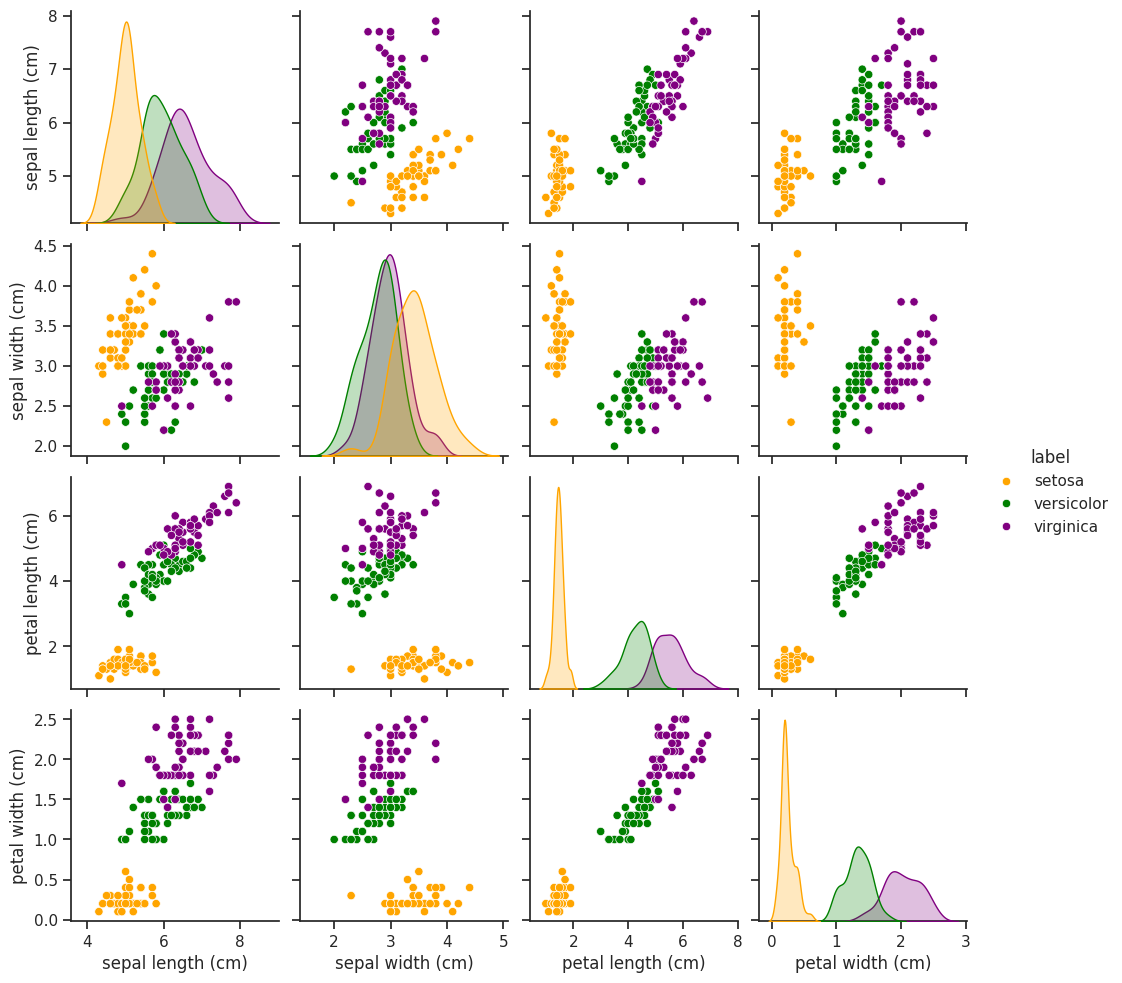

/usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


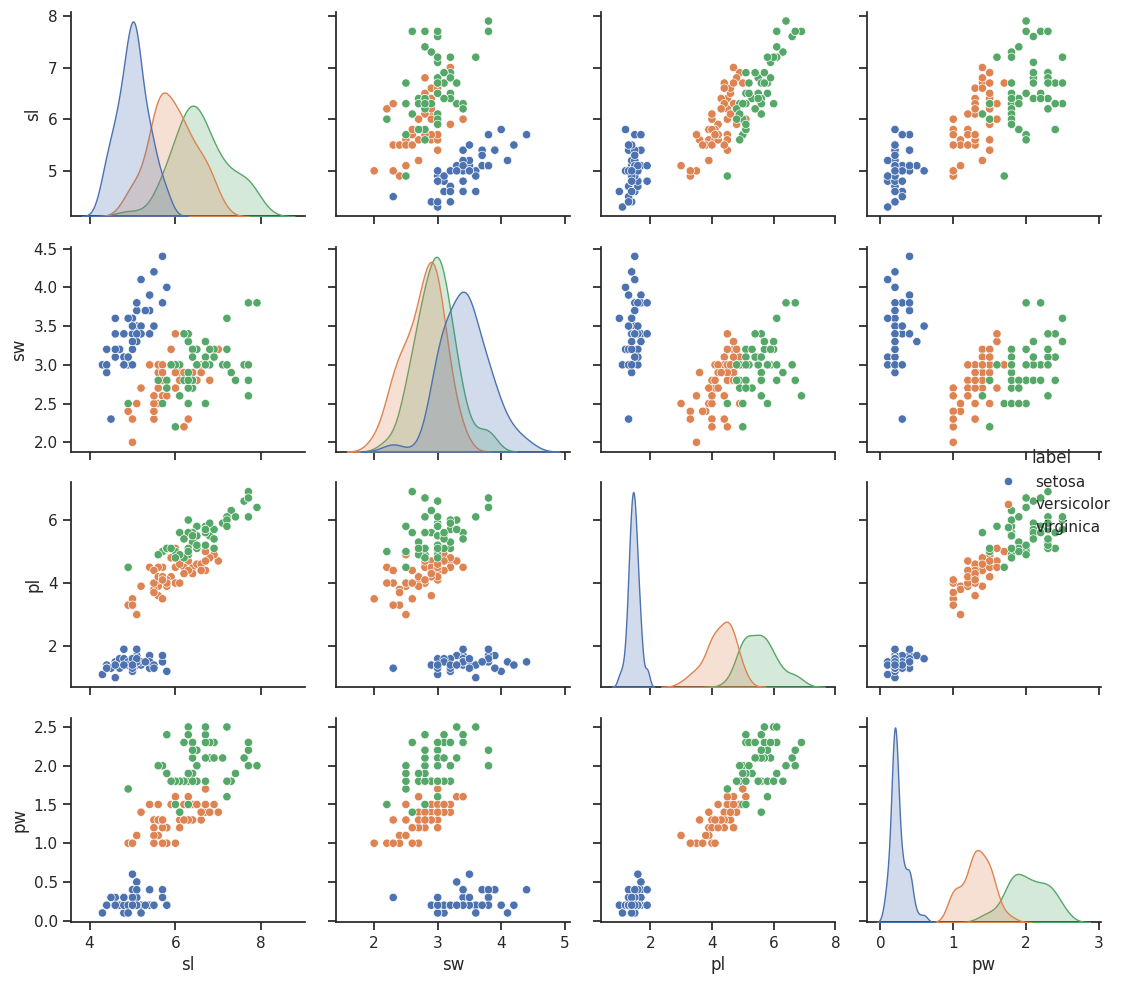

/usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


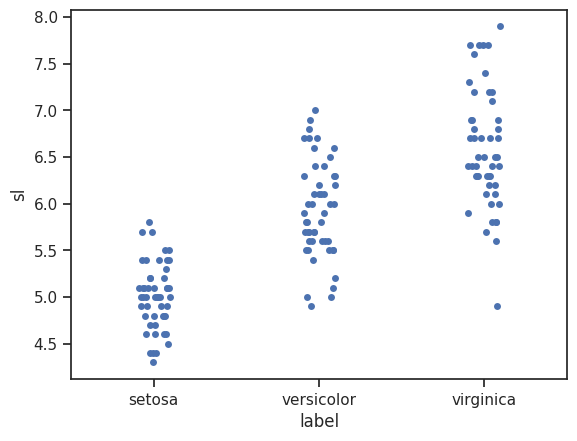

In [2]:
# Load Iris Dataset - see fig 2.11 in Murphy


import numpy as np
import matplotlib.pyplot as plt
import os
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
import seaborn as sns;
sns.set(style="ticks", color_codes=True)

try:
    import pandas as pd
except ModuleNotFoundError:
    %pip install -qq pandas
    import pandas as pd
pd.set_option('display.precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows

try:
    import sklearn
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    import sklearn
from sklearn.datasets import load_iris
iris = load_iris()

# Extract numpy arrays
X = iris.data
y = iris.target

# Convert to pandas dataframe
df = pd.DataFrame(data=X, columns=iris.feature_names)
df['label'] = pd.Series(iris.target_names[y], dtype='category')

# we pick a color map to match that used by decision tree graphviz
#cmap = ListedColormap(['#fafab0','#a0faa0', '#9898ff']) # orange, green, blue/purple
#cmap = ListedColormap(['orange', 'green', 'purple'])
palette = {'setosa': 'orange', 'versicolor': 'green', 'virginica': 'purple'}

g = sns.pairplot(df, vars = df.columns[0:4], hue="label", palette=palette)
#g = sns.pairplot(df, vars = df.columns[0:4], hue="label")
pml.savefig('iris_scatterplot_purple.pdf')
plt.show()


# Change colum names
iris_df = df.copy()
iris_df.columns =  ['sl', 'sw', 'pl', 'pw'] + ['label']

g = sns.pairplot(iris_df, vars = iris_df.columns[0:4], hue="label")
plt.tight_layout()
pml.savefig('iris_pairplot.pdf')
plt.show()


sns.stripplot(x="label", y="sl", data=iris_df, jitter=True)
pml.savefig('iris_sepal_length_strip_plot.pdf')
plt.show()


We are going to build up the model for binary logistic regression in S:2.4.3 of murphy to determine whether features indicate a virginica or not. To do that we will build a model of the form
$$p(y|\textbf{x},\theta) = Ber(y|\mathbf{\sigma}(\mathbf{w}^\intercal \mathbf{x} + b)$$

In [3]:
# reformat data to match binary classification problem (is it a virginica)
xfeature = X.T
ylabel = np.expand_dims((y==2).astype('int'),0)
Ndata = xfeature.shape[1]

In [4]:
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
config = tf.ConfigProto()
sess = tf.Session(config=config)

Instructions for updating:
non-resource variables are not supported in the long term


When building up the model, we can naively implement $\log \mathbb{P}\left( y = 1 \right)$ as $\text{tf.nn.log( tf.nn.sigmoid( sig_arg ) ) }$, or we can apply the $\text{log-sum-exp}$ trick we discussed in class and can be found in $\mathcal{S}2.5.4$ of Murphy. In the code below the final two lines (which are commented out) calculate the naive way, while the two preceding lines apply the trick. Try running with both, and note the behavior if you train for a very long time (1000k steps) without the trick.

In [5]:
w = tf.Variable(np.zeros(shape=(1,4)),dtype=tf.float32)
b = tf.Variable(1.0,dtype=tf.float32)
x = tf.placeholder(dtype=tf.float32,shape=(4,Ndata))
y_data = tf.placeholder(dtype=tf.float32,shape=(1,Ndata))

sig_arg = tf.einsum('ij,jd->id',w,x) + b
p_y_eq_1 = tf.nn.sigmoid(sig_arg)
logp_y_eq_1 = tf.expand_dims(0 - tf.reduce_logsumexp(tf.concat([tf.zeros(shape=(1,Ndata)),-sig_arg],axis=0),axis=0),0)
logp_y_eq_0 = tf.expand_dims(0 - tf.reduce_logsumexp(tf.concat([tf.zeros(shape=(1,Ndata)), sig_arg],axis=0),axis=0),0)
#logp_y_eq_1 = tf.log(p_y_eq_1)
#logp_y_eq_0 = tf.log(1.-p_y_eq_1)

Here is our cross entropy loss. From here on out I recommend using the [Adam optimizer](https://arxiv.org/pdf/1412.6980.pdf%5D), although you can find other choices in the [Tensorflow API](https://www.tensorflow.org/api_docs/python/tf/compat/v1/train), including the [vanilla gradient descent](https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/GradientDescentOptimizer) we implemented in homework 1. Play with the different choices and note the different performance - in general Adam is a good default choice, although the best optimizer will be problem dependent and will need to be played with for a given application/architecture. Keras (a higher-level interface that wraps around the low-end tensorflow API) has more options if you work in TF2.

In [23]:
CE_LOSS = -tf.reduce_mean(tf.einsum('id,id->d',y_data,logp_y_eq_1) + tf.einsum('id,id->d',1.-y_data,logp_y_eq_0))
optimizer_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(CE_LOSS)
sess.run(tf.global_variables_initializer()) #initialize model

Start optimizing, and print out the accuracy every 100 steps. You'll notice when printing out the cross entropy loss that it isn't super interpretable. A less rigorous but clearer option is to print the accuracy, taking the argmax of which class is most likely as a prediction and counting the fraction of cases where that predictor is correct. You'll see we get into the high 90s very easily with this model as long as you pick a reasonable learning rate, and you use the log-sum-exp trick to avoid a bad initial guess making your model unstable.

i.e. at the end of training we get a cross entropy loss of 0.12 (is that good?) but a ~99% accuracy (clearly good).

In [ ]:
losslog = []
losslog_acc = []

for training_step in range(5000):
  data_dict = {x:xfeature,y_data:ylabel}
  sess.run(optimizer_step,feed_dict=data_dict)
  prediction=(sess.run(p_y_eq_1,feed_dict=data_dict)>0.5).astype(int)
  # uncomment to print out accuracy or loss during training
  #if (training_step%10==0):
    #print('Accuracy: ' + str(np.sum(ylabel==prediction)/Ndata))
    # print('(CE_loss) = (' + str(sess.run(CE_LOSS,feed_dict=data_dict)) )

  losslog.append(sess.run(CE_LOSS,feed_dict=data_dict))
  losslog_acc.append(np.sum(ylabel==prediction)/Ndata)

Finally, we'll want to postprocess our model. Shown is one way to visualize how the CE loss has evolved during training. There is no way to know when the model is done training - what we're looking for is that the model has plateaued and more steps $\textit{on a x-log scale}$ isn't leading to increased accuracy. We'll see when we move on to deep learning that this isn't necessarily a good stopping criteria, but fine for now.

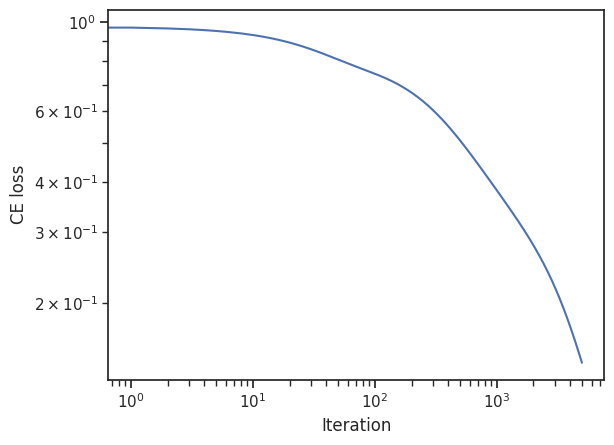

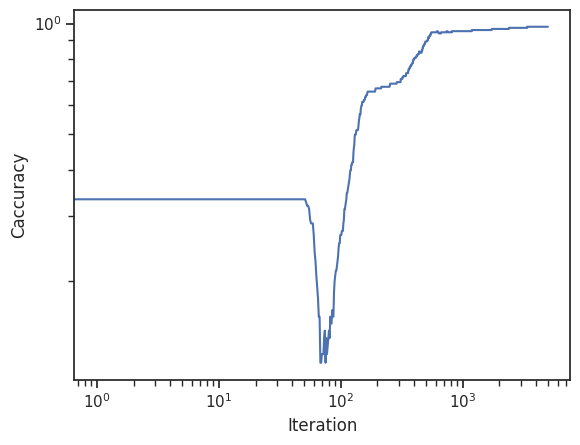

In [25]:
plt.figure()
plt.loglog(losslog)
plt.xlabel('Iteration')
plt.ylabel('CE loss')
plt.show()

plt.figure()
plt.loglog(losslog_acc)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()
